# Tarea 1 - Ciencia de Datos
### Por: Gustavo Hernández Angeles

In [2]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
from time import perf_counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.cluster import AgglomerativeClustering

# Debido al warning 
# UserWarning: KMeans is known to have a memory leak on Windows with MKL, 
# when there are less chunks than available threads. 
# You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
import os

os.environ["OMP_NUM_THREADS"] = "1"

# 1. Implementación de algoritmos

In [3]:
def distancia_minkowski(x : np.ndarray, y : np.ndarray,
                        p : float):
    """
    Distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    x : Vector X, mismas dimensiones que Y
    y : Vector Y, mismas dimensiones que X
    p : Orden
    
    Devuelve
    --------
    distancia : Magnitud distancia entre X a Y de orden p.
    """
    return np.sum(np.abs(x-y)**p)**(1/p)


def jerarquico_aglomerativo(X : np.ndarray, n_clusters : int = 2, umbral : float = None, 
                            enlace = "single-linkage", p = 2) -> np.ndarray:
    """
    Clustering Jerárquico Aglomerativo.
    -----------------------------------
    
    Calcula los clusters mediante el Clusterin Jerárquico Aglomerativo.  
    Se implementa la distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    ``X`` : Matriz de datos.
    ``n_clusters`` : Número de clusters. 
        (Originalmente creí que especificabamos el numero de clusters)
    ``umbral`` : Umbral de distancia para detener el algoritmo.
    ``enlace`` : Tipo de enlace. Puede ser "single-linkage", "complete-linkage" o "average-linkage".
    ``p`` : Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``label`` : El label[i] representa el indice del cluster al que pertenece la i-esima observación
    """
    
    # Primero verificamos que el enlace de input sea correcto
    if enlace not in ["single-linkage", "complete-linkage", "average-linkage"]:
        raise ValueError(f"Argumento 'enlace' puede tener valores ('single-linkage',"\
            f"'complete-linkage', 'average-linkage'), se introdujo el valor '{enlace}'.")
    
    n = X.shape[0]
    
    # Cada punto es un cluster
    clusters = [[i] for i in range(n)]
    
    # Inicializar matriz de disimilitud
    matriz_disim = np.array([[distancia_minkowski(X[i], X[j], p) 
                              for j in range(n)] 
                             for i in range(n)])
    
    # Hacer hasta obtener n_clusters clusters
    for t in range(n-n_clusters):
        
        # Encontrar los clusters más cercanos
        minimo = np.inf
        for i in range(n-t):
            for j in range(n-t):
                if i != j and i < j and matriz_disim[i,j] < minimo:
                    minimo = matriz_disim[i,j]
                    min_i = i
                    min_j = j
        
        # Detenerse si la distancia menor es mayor al umbral
        if umbral is not None and minimo > umbral:
            break
        
        clusters[min_i] += clusters[min_j]
        clusters.pop(min_j)
        
        # Distancias segun enlace
        if enlace == "single-linkage":
            # Distancia mínima del cluster ij al resto de clusters
            distancias_nuevoCluster = np.array([min(matriz_disim[min_i,k], matriz_disim[min_j,k]) 
                                                for k in range(n-t)
                                                if k != min_i and k != min_j])
            distancias_nuevoCluster = np.insert(distancias_nuevoCluster, min_i, 0)
        elif enlace == "complete-linkage":
            # Distancia maxima del cluster ij al resto de clusters
            distancias_nuevoCluster = np.array([max(matriz_disim[min_i,k], matriz_disim[min_j,k])
                                                for k in range(n-t)
                                                if k != min_i and k != min_j])
            distancias_nuevoCluster = np.insert(distancias_nuevoCluster, min_i, 0)
        elif enlace == "average-linkage":
            distancias_nuevoCluster = np.zeros(n-t-1)
            n_ij = len(clusters[min_i])
            for cluster_k in clusters[:min_i] + clusters[min_i+1:]:
                n_k = len(cluster_k)
                indice_k = clusters.index(cluster_k)
                for vector_k in cluster_k:
                    for vector_ij in clusters[min_i]:
                        distancias_nuevoCluster[indice_k] += distancia_minkowski(vector_k, vector_ij, p)
                distancias_nuevoCluster[indice_k] /= n_ij * n_k
        
        # Actualizar matriz de disimilaridad
        matriz_disim = np.delete(matriz_disim, min_j, axis = 0)
        matriz_disim = np.delete(matriz_disim, min_j, axis = 1)
        matriz_disim[min_i] = distancias_nuevoCluster
        matriz_disim[:,min_i] = distancias_nuevoCluster
    
    # Devolver etiquetas
    labels = np.full(n,-1) # Los outliers tendrán indice -1
    for i in range(n_clusters):
        for indice in clusters[i]:
            labels[indice] = i
    
    return labels


def k_medias(X : np.ndarray, n_clusters : int, 
             max_iter = 100, epsilon = 1e-4, p = 2,
             semilla : int = 42):
    """
    Algoritmo K-means
    -----------------
    
    Clustering mediante el algoritmo K-means.  
    Se implementa la distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    ``X`` : Matriz de datos.
    ``n_clusters`` : Número de clusters.
    ``max_iter`` : Número máximo de iteraciones.
    ``epsilon`` : Conergencia del algoritmo.
    ``p`` : Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``centroides`` : ndarray (n_clusters, n_features)

    ``label`` : El label[i] representa el indice del centroide más cercano a la i-esima observación.
    """
    n = X.shape[0]
    labels = np.zeros(n)
    
    # Se proponen clusters
    np.random.seed(semilla)
    centroides = X[np.random.choice(n, n_clusters, replace = False)]
    centroides_pasados = None
    
    for i in range(max_iter):
        
        # Condicion de convergencia
        if centroides_pasados is not None:
            # Calculamos la norma de la diferencia entre los centroides actuales y los anteriores
            diferencias = [distancia_minkowski(centroides[i], centroides_pasados[i], p) 
                           for i in range(n_clusters)]
            if max(diferencias) < epsilon:
                break
        
        # Rellenar los clusters
        clusters = [[] for _ in range(n_clusters)]
        for i in range(n):
            c_i = np.argmin([distancia_minkowski(X[i], centroide, p)**p 
                             for centroide in centroides])
            clusters[c_i].append(X[i])
            labels[i] = c_i
            
        
        # Guardar centroides actuales
        centroides_pasados = centroides.copy()
        
        # Actualizar centroides como la media de sus puntos
        for j in range(n_clusters):
            
            # Si está vacío el cluster, no se actualiza
            if not clusters[j]:
                continue
            
            centroides[j] = np.mean(clusters[j], axis = 0)
    
                
    
    return (centroides, labels)


def coeficiente_silueta(X, labels, p=2):
    """
    Silueta promedio de un clustering.
    -----------------------------------
    
    Calcula el coeficiente de silueta promedio de un clustering.  
    Se implementa la distancia de Minkowski de orden p.

    Parámetros
    ----------
    ``clusters`` : list 
        Lista de clusters, cada cluster (lista) contiene los puntos que le pertenecen.
    ``p`` : float 
        Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``s_k_promedio``: float 
        Coeficiente de silueta promedio.
    """
    # Numero de clusters y de puntos
    n_clusters = len(set(labels))
    n = X.shape[0]
    
    clusters = [[X[i] for i in range(n) if label == labels[i]] for label in range(n_clusters)]
        
    # Inicializar s_k en ceros
    s_k = np.zeros(n_clusters)
    
    # Iteramos sobre los clusters
    for k in range(n_clusters):
        vectores_k = clusters[k]
        
        # Dejamos s_k = 0 para cuando
        # el cluster está vacío o tiene 1 elemento.
        # https://en.wikipedia.org/wiki/Silhouette_(clustering)
        if len(vectores_k) == 0 or len(vectores_k) == 1:
            continue
        
        # Iteramos sobre cada vector del cluster
        for vector in vectores_k:
            # Calcular a_i
            a_i = np.mean([distancia_minkowski(vector, vector_k, p)
                           for vector_k in vectores_k
                           if not np.array_equal(vector, vector_k)])
            
            # Calcular b_ic (tamaño k-1) y obtener b_i
            b_ic = [np.mean([distancia_minkowski(vector, vector_c, p)
                                for vector_c in clusters[c]])
                            for c in range(n_clusters) if c != k]
            b_i = min(b_ic)
            
            s_i = (b_i - a_i) / max(a_i, b_i)
            
            # acumulamos s_i de cada cluster
            s_k[k] += s_i
    
    # Regresamos el promedio de todas las s_i
    s_k_promedio = s_k.sum() / n
    return s_k_promedio

# 2. Evaluación de resultados.

## 2.1. El conjunto de datos

Este conjunto de datos es sobre tres especies diferentes de la flor Iris, 
las cuales se definen en términos de las dimensiones de sus sépalos y pétalos.

El objetivo es realizar un análisis sobre las distintas especies de Iris 
utilizando las herramientas implementadas anteriormente, junto con métodos de visualización.

1. *Número de id*: 1 a 150  
2. *Sepal.Length*: Longitud del sépalo (cm)  
3. *Sepal.Width*: Ancho del sépalo (cm)  
4. *Petal.Length*: Longitud del pétalo (cm)  
5. *Petal.Width*: Ancho del pétalo (cm)  
6. *Species*: Especie de la flor (atributo de clase):  
    - setosa  
    - versicolor  
    - virginica 

In [4]:
# Se importa directamente mediante la librería de UCI ML.

# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = pd.DataFrame(iris.data.features)
y = pd.DataFrame(iris.data.targets)

df = pd.concat([X,y], axis = 1)


# Para input en los algoritmos
X_numpy = X.to_numpy()

# Renombramos las clases con 0, 1 y 2, todo esto para input
# de la función coeficiente_silueta.
y["class"] = y["class"].apply(lambda clase: 0
                              if clase == "Iris-setosa" else 1
                              if clase == "Iris-versicolor" else 2)
y_label = list(y["class"].to_numpy())

## 2.2. Describir la base de datos y comportamiento de variables

Una manera rápida de ver relaciones entre pares de variabels y su distribución es mediante una *gráfica de dispersión múltiple*. Utilizando `seaborn`, fácilmente podemos categorizar las gráficas por clase. También graficaremos la diagonal utilizando Kernel Density Estimation, cuyo kernel por defecto es el gaussiano.

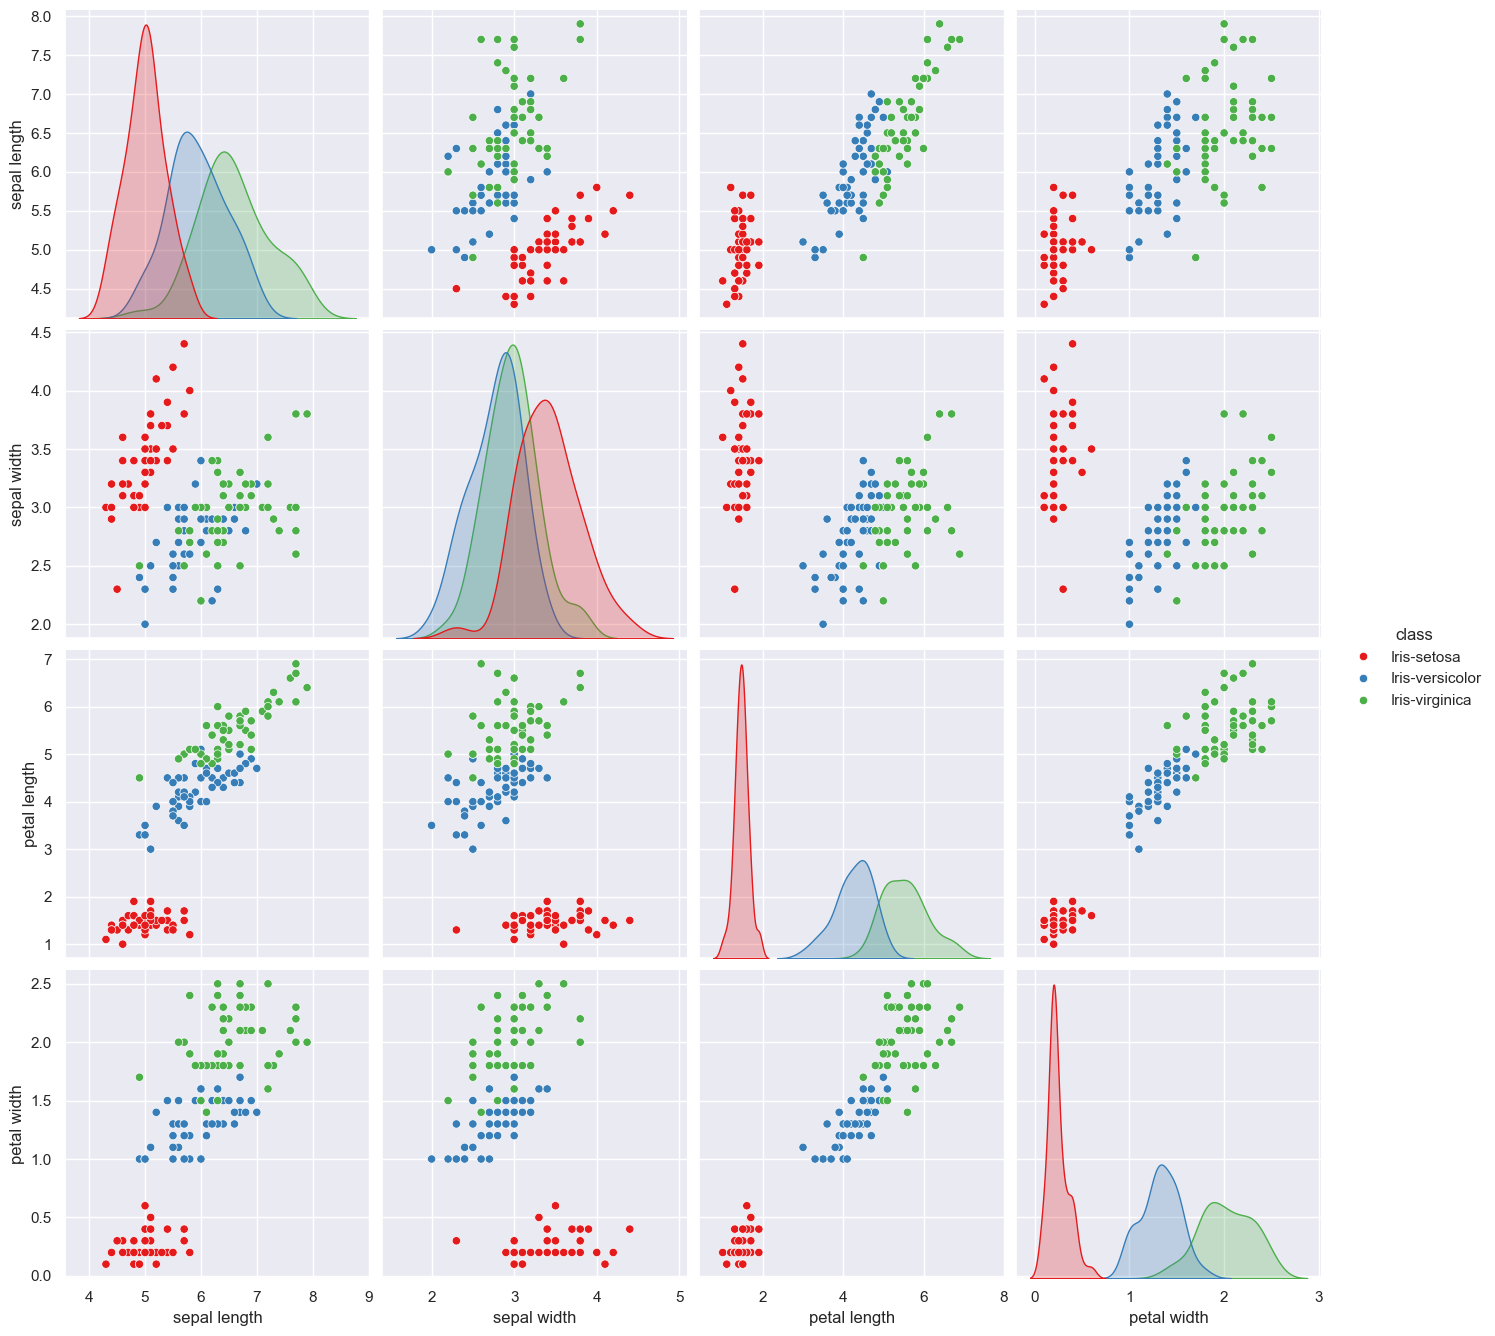

In [16]:
sns.set_theme("notebook")
sns.pairplot(df, hue="class", palette="Set1", height=3.4, diag_kind="kde")

Podemos ver como la clase Iris-setosa es linealmente separable de las otras dos clases en todas las features. Sin embargo, estas dos últimas no lo son; a veces pueden estar traslapadas unas con otras (*sepal width* vs *sepal length*).  

En particular, así viendo a puro ojo, podemos ver que en la variable *petal width* es donde las distribuciones parecen estar más disjuntas, podemos verlo con boxplots.

* Iris-setosa es fácilmente separable con respecto a esta variable.
* El percentil 75 del ancho del petalo en Iris-versicolor marca también el percentil 25 para la Iris-virginica.
    - Se ve facilmente que ~25% de observaciones de Iris-virginica se interpone con Iris-versicolor.
    - Similarmente, 30% de las observaciones de Versicolor se traslapa con Virginica.
    - Los traslapes no son tan severos como en otras features, pero siguen siendo considerables.

**Puede ser una feature importante a la hora de hacer clustering.**

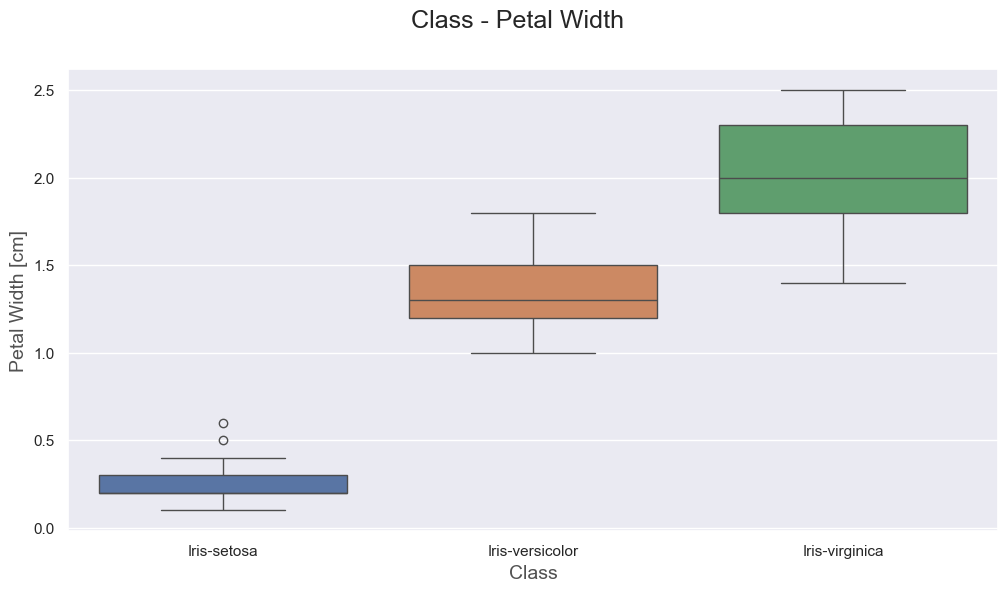

Porcentaje de traslape: Versicolor sobre Virginica 30.00%


In [17]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle("Class - Petal Width", size = 18)

sns.boxplot(data=df, x = "class", y = "petal width", ax = (ax), hue="class")
ax.set_xlabel("Class",size = 14,alpha=0.8)
ax.set_ylabel("Petal Width [cm]",size = 14,alpha=0.8)
plt.show()


# Determinar porcentaje de obs versicolor sobre virginica.
min_virginica = df[df["class"] == "Iris-virginica"]["petal width"].min()
n_versi_sobre_virginica = df[df["class"] == "Iris-versicolor"]["petal width"].apply(lambda valor: 1
                                                                                    if valor > min_virginica else 0).sum()

porcentaje_vers_sobre_virg = n_versi_sobre_virginica / df[df["class"] == "Iris-versicolor"].count(axis=0).iloc[0]

print(f"Porcentaje de traslape: Versicolor sobre Virginica {porcentaje_vers_sobre_virg:.2%}")

Viendo de nuevo al pairplot, podemos ver que donde más podríamos pensar que se separan las clases es en el scatterplot entre *petal length* y *petal width*.  
Veamoslo con un KDE en dos dimensiones.

Puede parecer que son completamente separables cuando utilizamos `fill=True`, pero  no es así.

<Axes: xlabel='petal width', ylabel='petal length'>

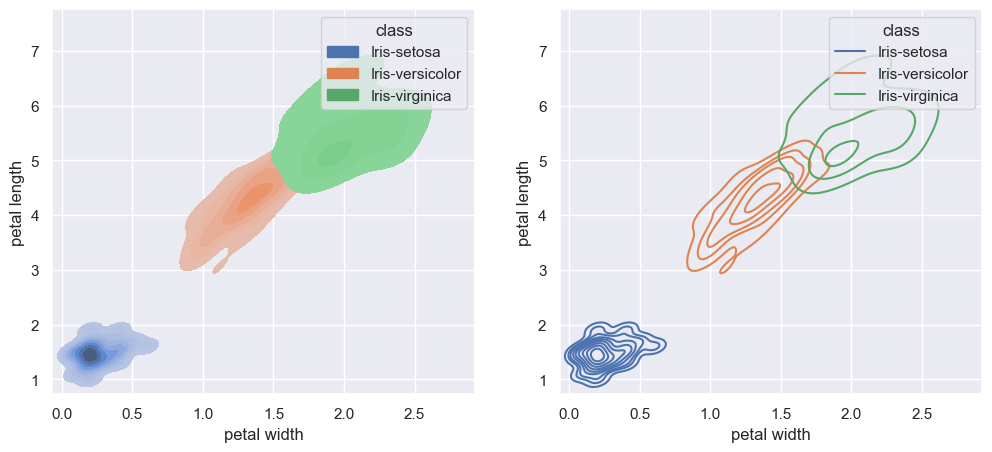

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(df, x="petal width", y="petal length", hue="class", fill=True, ax=ax[0])
sns.kdeplot(df, x="petal width", y="petal length", hue="class", fill=False, ax=ax[1])


Probamos también con un mapa de calor, para ver relaciones lineales entre las features (dejando por un momento de fuera la tarea de clasificación).  
Podemos observar correlaciones masivas para los pares (sepal length, petal length) con 0.87, (sepal length, petal width) con 0.82 y (petal length, petal width) con 0.96.

<Axes: >

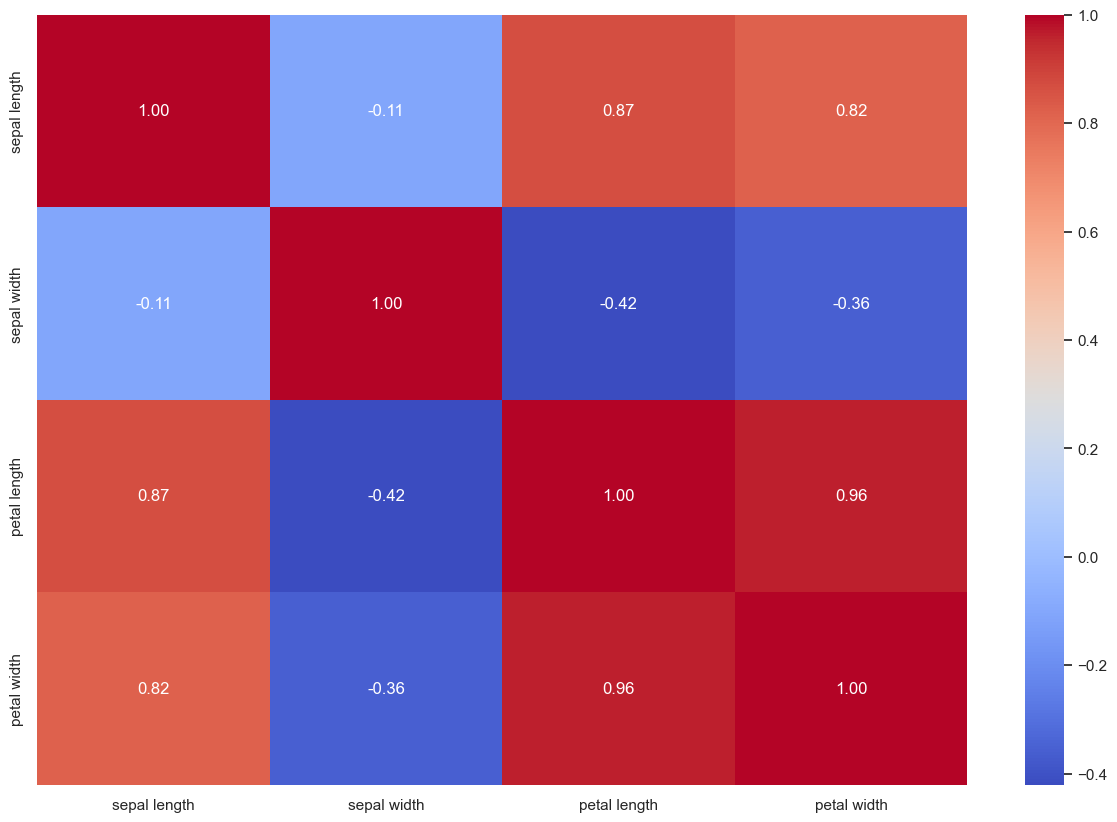

In [19]:
plt.figure(figsize=(15,10))

columnas = df.columns[:-1] # Todas menos la clase

corr_matrix = df[columnas].corr()

sns.heatmap(corr_matrix, cmap="coolwarm", fmt = ".2f", annot=True)

### 2.1.1. Veamos las mismas visualizaciones con los datos estandarizados.

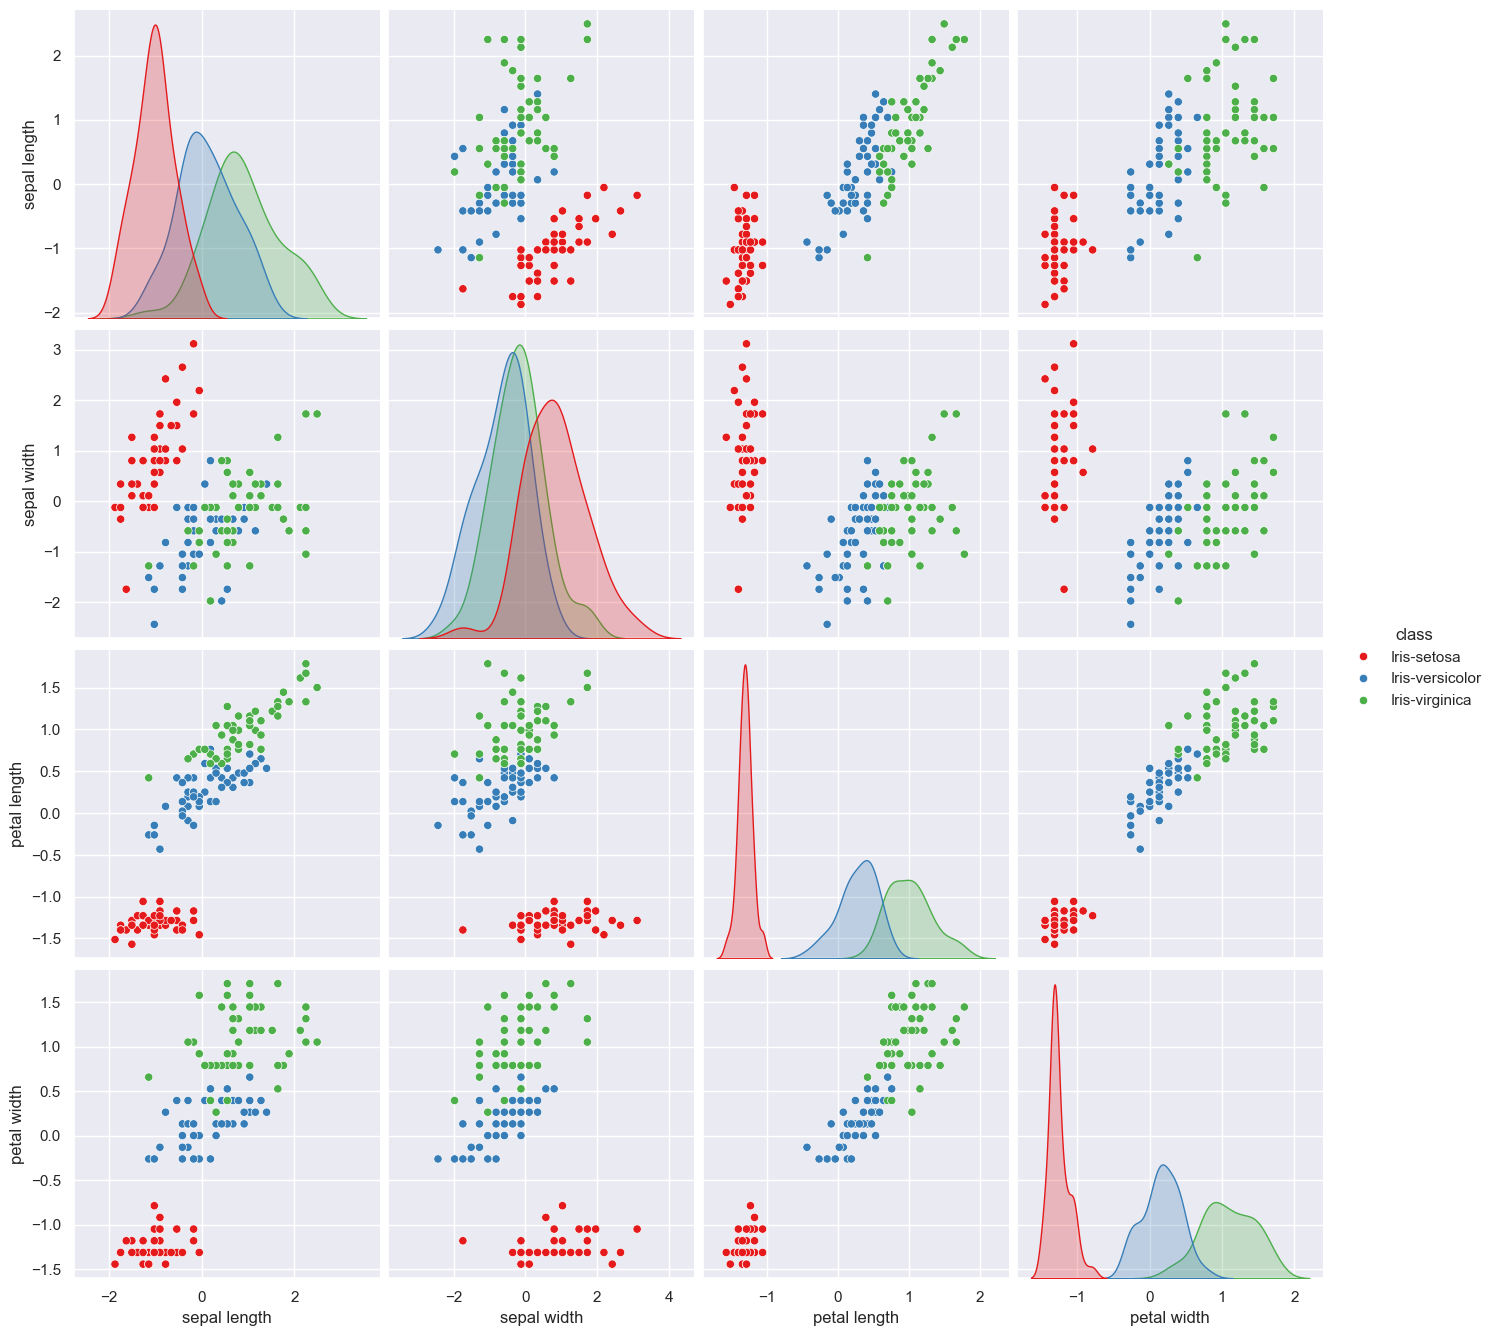

In [20]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[df.columns[:-1]]), columns=df.columns[:-1])
df_scaled = pd.concat([df_scaled, df["class"]], axis = 1)

sns.pairplot(df_scaled, hue="class", palette="Set1", height=3.4, diag_kind="kde")

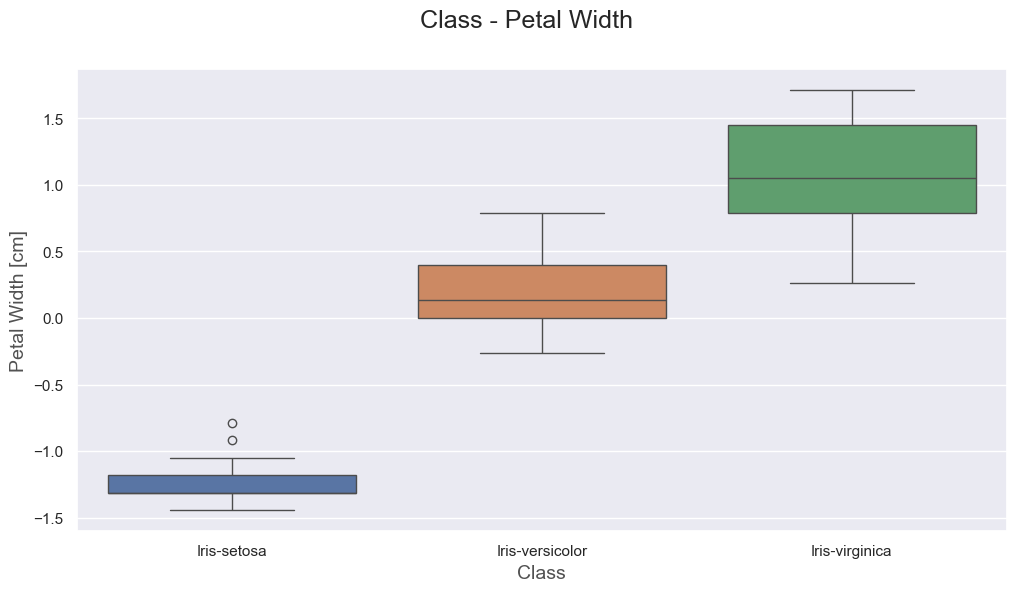

Porcentaje de traslape: Versicolor sobre Virginica 30.00%


In [21]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle("Class - Petal Width", size = 18)

sns.boxplot(data=df_scaled, x = "class", y = "petal width", ax = (ax), hue="class")
ax.set_xlabel("Class",size = 14,alpha=0.8)
ax.set_ylabel("Petal Width [cm]",size = 14,alpha=0.8)
plt.show()


# Determinar porcentaje de obs versicolor sobre virginica.
min_virginica = df_scaled[df_scaled["class"] == "Iris-virginica"]["petal width"].min()
n_versi_sobre_virginica = df_scaled[df_scaled["class"] == "Iris-versicolor"]["petal width"].apply(lambda valor: 1
                                                                                    if valor > min_virginica else 0).sum()

porcentaje_vers_sobre_virg = n_versi_sobre_virginica / df_scaled[df_scaled["class"] == "Iris-versicolor"].count(axis=0).iloc[0]

print(f"Porcentaje de traslape: Versicolor sobre Virginica {porcentaje_vers_sobre_virg:.2%}")

<Axes: >

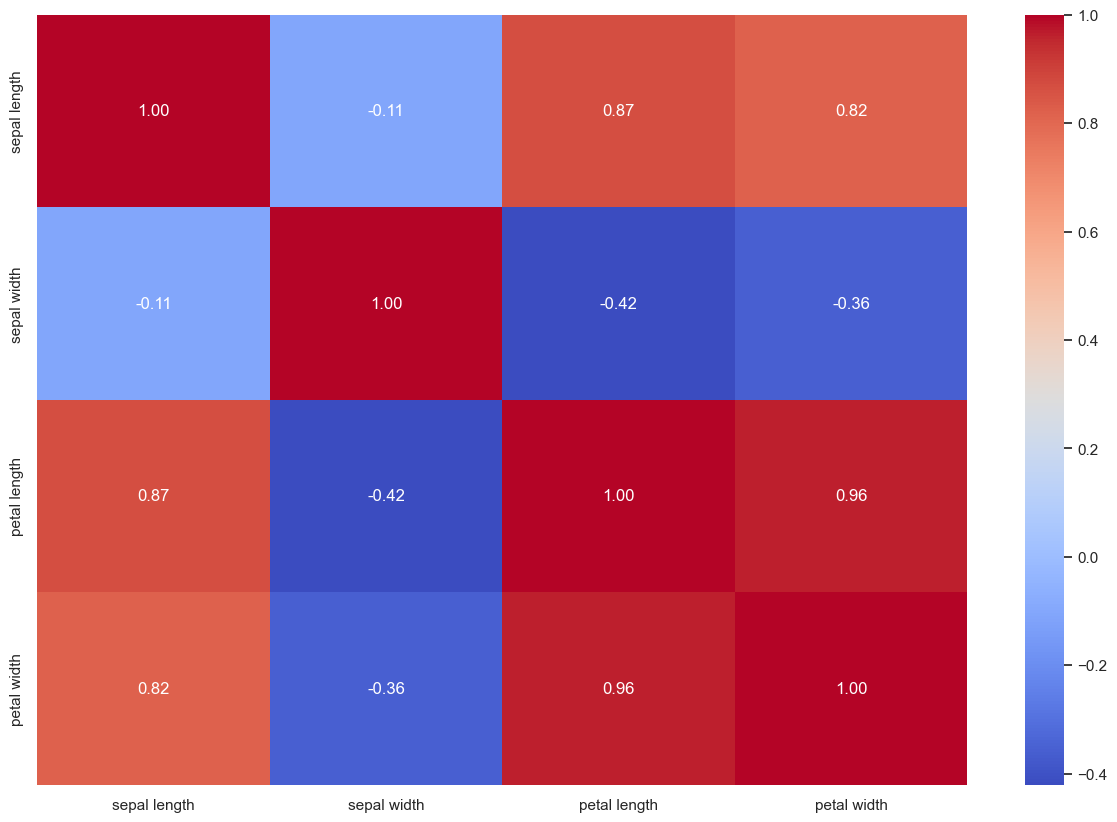

In [22]:
plt.figure(figsize=(15,10))

columnas = df_scaled.columns[:-1] # Todas menos la clase

corr_matrix = df_scaled[columnas].corr()

sns.heatmap(corr_matrix, cmap="coolwarm", fmt = ".2f", annot=True)

<Axes: xlabel='petal width', ylabel='petal length'>

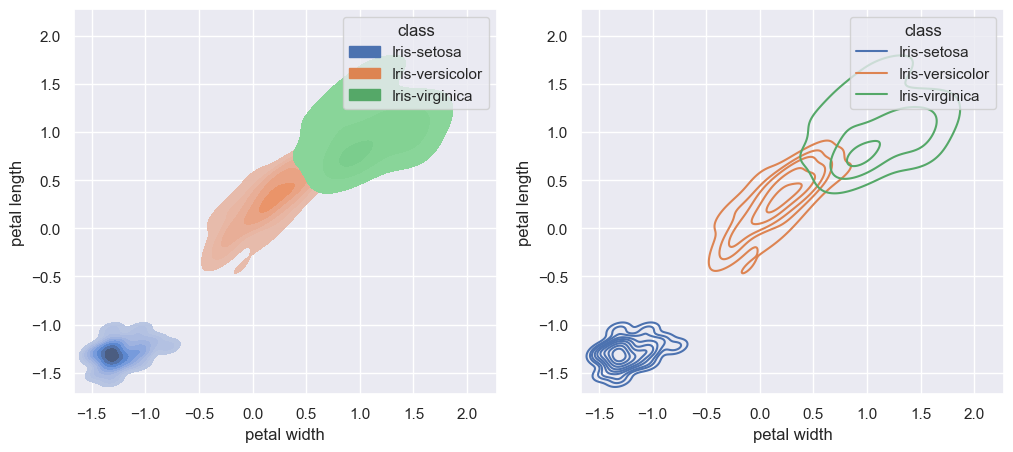

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.set_theme("notebook")
sns.kdeplot(df_scaled, x="petal width", y="petal length", hue="class", fill=True, ax=ax[0])
sns.kdeplot(df_scaled, x="petal width", y="petal length", hue="class", fill=False, ax=ax[1])


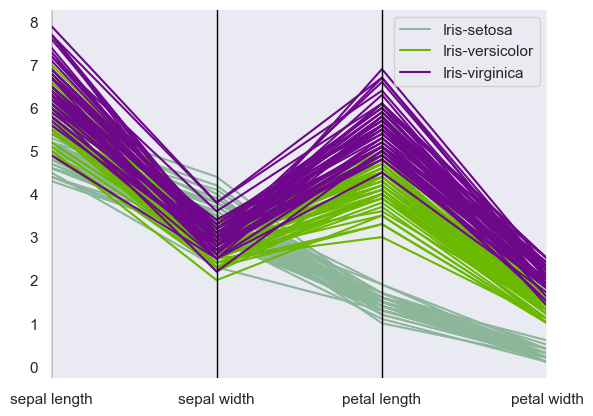

In [25]:
from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(frame=df, class_column="class")
plt.show()